# Jax-Bayes MNIST Example --- Bayesian MCMC Approach
To run on Colab, just run the cells sequentially
## Setup the Environment

In [ ]:
#see https://github.com/google/jax#pip-installation
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.51-cp36-none-manylinux2010_x86_64.whl
!pip install --upgrade jax
!pip install git+https://github.com/deepmind/dm-haiku
#you may have to retart your runtime and re-run this cell due to dependency 
# conflict with pre-installed tensorflow.
!pip install git+https://github.com/jamesvuc/jax-bayes

In [9]:
import haiku as hk

import jax.numpy as jnp
from jax.experimental import optimizers
import jax

import jax_bayes

import sys, os, math, time
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow_datasets as tfds

## Loat Data and Create the Model *(same as traditional)*

In [5]:
def load_dataset(split, is_training, batch_size):
	ds = tfds.load('mnist:3.*.*', split=split).cache().repeat()
	if is_training:
		ds = ds.shuffle(10 * batch_size, seed=0)
	ds = ds.batch(batch_size)
	return tfds.as_numpy(ds)

def net_fn(batch):
	""" Standard LeNet-300-100 MLP """
	x = batch["image"].astype(jnp.float32) / 255.

	# we initialize the model with zeros since we're going to construct intiial 
	# samples for the weights with additive Gaussian noise
	sig = 0.0
	mlp = hk.Sequential([
		hk.Flatten(),
		hk.Linear(300, w_init=hk.initializers.RandomNormal(stddev=sig),
					   b_init=hk.initializers.RandomNormal(stddev=sig)), 
		jax.nn.relu, 
		hk.Linear(100, w_init=hk.initializers.RandomNormal(stddev=sig),
					   b_init=hk.initializers.RandomNormal(stddev=sig)), 
		jax.nn.relu, 
		hk.Linear(10,  w_init=hk.initializers.RandomNormal(stddev=sig),
					   b_init=hk.initializers.RandomNormal(stddev=sig))
		])

	return mlp(x)

## Build the Optimizer, Loss, Accuracy, and ~Train Step~ MCMC Step

In [7]:
#hyperparameters
lr = 5e-3
reg = 1e-4
num_samples = 10 # number of samples to approximate the posterior
init_stddev = 0.1 # initial distribution for the samples will be N(0, 0.1)

#instantiate the model --- same as regular case
net = hk.transform(net_fn)

#build the sampler instead of optimizer
sampler_fns = jax_bayes.mcmc.rms_langevin_fns
seed = 0
key = jax.random.PRNGKey(seed)
sampler_init, sampler_propose, sampler_update, sampler_get_params = \
  sampler_fns(key, num_samples=num_samples, step_size=lr, init_stddev=init_stddev)

# loss is the same as the regular case! This is because in regular ML, we're minimizing
# the negative log-posterior logP(params | data) = logP(data | params) + logP(params) + constant
# i.e. finding the MAP estimate.
def loss(params, batch):
  logits = net.apply(params, jax.random.PRNGKey(0), batch)
  labels = jax.nn.one_hot(batch['label'], 10)
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) 
            for p in jax.tree_leaves(params))
  softmax_crossent = - jnp.mean(labels * jax.nn.log_softmax(logits))

  return softmax_crossent + reg * l2_loss

#the log-probability is the negative of the loss
logprob = lambda p,b : - loss(p, b)

@jax.jit
def accuracy(params, batch):
  #auto-vectorize over the samples of params! only in JAX...
  pred_fn = jax.vmap(net.apply, in_axes=(0, None, None))

  # this is crucial --- integrate (i.e. average) out the parameters
  preds = jnp.mean(pred_fn(params, None, batch), axis=0)

  return jnp.mean(jnp.argmax(preds, axis=-1) == batch['label'])

#build the mcmc step. This is like the opimization step, but for sampling
@jax.jit
def mcmc_step(i, sampler_state, sampler_keys, batch):
  #extract parameters
  params = sampler_get_params(sampler_state)
  
  #form a partial eval of logprob on the data
  logp = lambda p: logprob(p,  batch) #can make this 1-line?
  
  # evaluate *per-sample* gradients
  fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

  # generat proposal states for the Markov chains
  sampler_prop_state, new_keys = sampler_propose(i, dx, sampler_state, 
                          sampler_keys)
  
  #we don't need to re-compute gradients for the accept stage
  fx_prop, dx_prop = fx, dx

  # accept the proposal states for the markov chain
  sampler_state, new_keys = sampler_update(i, fx, fx_prop, 
                                           dx, sampler_state, 
                                           dx_prop, sampler_prop_state, 
                                           new_keys)
  
  return jnp.mean(fx), sampler_state, new_keys

## Load Batch Iterators & Do the ~Optimization~ Sampling

In [13]:
# load the data into memory and create batch iterators
train_batches = load_dataset("train", is_training=True, batch_size=1_000)
val_batches = load_dataset("train", is_training=False, batch_size=10_000)
test_batches = load_dataset("test", is_training=False, batch_size=10_000)

In [14]:
%%time

#get a single sample of the params using the normal hk.init(...)
params = net.init(jax.random.PRNGKey(42), next(train_batches))

# get a SamplerState object with `num_samples` params along dimension 0
# generated by adding Gaussian noise (see sampler_fns(..., init_dist='normal'))
sampler_state, sampler_keys = sampler_init(params)

# iterate the the Markov chain
for step in range(10_001):
  train_logprob, sampler_state, sampler_keys = \
    mcmc_step(step, sampler_state, sampler_keys, next(train_batches))
  if step % 500 == 0:
    params = sampler_get_params(sampler_state)
    val_acc = accuracy(params, next(val_batches))
    test_acc = accuracy(params, next(test_batches))
    print(f"step = {step}"
        f" | val acc = {val_acc:.3f}"
        f" | test acc = {test_acc:.3f}")

step = 0 | val acc = 0.058 | test acc = 0.058
step = 500 | val acc = 0.685 | test acc = 0.706
step = 1000 | val acc = 0.875 | test acc = 0.882
step = 1500 | val acc = 0.912 | test acc = 0.918
step = 2000 | val acc = 0.928 | test acc = 0.931
step = 2500 | val acc = 0.944 | test acc = 0.938
step = 3000 | val acc = 0.953 | test acc = 0.943
step = 3500 | val acc = 0.957 | test acc = 0.947
step = 4000 | val acc = 0.959 | test acc = 0.949
step = 4500 | val acc = 0.961 | test acc = 0.952
step = 5000 | val acc = 0.963 | test acc = 0.954
step = 5500 | val acc = 0.969 | test acc = 0.956
step = 6000 | val acc = 0.971 | test acc = 0.957
step = 6500 | val acc = 0.974 | test acc = 0.960
step = 7000 | val acc = 0.974 | test acc = 0.961
step = 7500 | val acc = 0.976 | test acc = 0.962
step = 8000 | val acc = 0.975 | test acc = 0.962
step = 8500 | val acc = 0.977 | test acc = 0.963
step = 9000 | val acc = 0.981 | test acc = 0.964
step = 9500 | val acc = 0.981 | test acc = 0.964
step = 10000 | val acc =

Note that the wall time is ~1m6s for the MCMC algorithm, compared to ~55s for the optimization, ***despite the MCMC making 10x more computations***. This is a result of JAX efficiencies and modern accelerators (GPUs).

## Uncertainty Analysis

This will illustrate how logits perform when we use them to proxy uncertainty about predictions. We take the *histogram* over the class predictions to give the uncertainty of the predictions. We measure
1. Accuracy for a given certainty threshold (i.e. P(predicted class > threshold));
2. Entropy of the predictive distribution (this measures "surprise" for a distribution); and
3. How accuracy changes as we increase certainty.

In [22]:
def posterior_predictive(params, batch):
  """computes the posterior_predictive P(class = c | inputs, params) using a histogram
  """
  pred_fn = lambda p:net.apply(p, jax.random.PRNGKey(0), batch) 
  pred_fn = jax.vmap(pred_fn)

  logit_samples = pred_fn(params) # n_samples x batch_size x n_classes
  pred_samples = jnp.argmax(logit_samples, axis=-1) #n_samples x batch_size

  n_classes = logit_samples.shape[-1]
  batch_size = logit_samples.shape[1]
  probs = np.zeros((batch_size, n_classes))
  for c in range(n_classes):
    idxs = pred_samples == c
    probs[:,c] = idxs.sum(axis=0)

  return probs / probs.sum(axis=1, keepdims=True)

acc = 0.9667 | cert acc = 0.9714 | pct cert = 0.9856  | entropy = 0.1558 vs theoretical maximum 2.3026


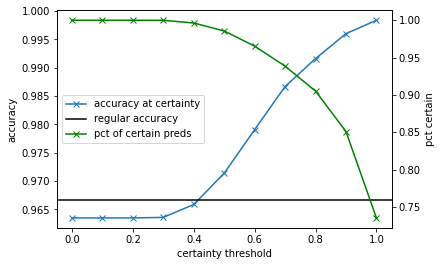

In [23]:
# this is the same code from the optimization example, but using the histogram 
# posterior predictive instead of logits.

from jax_bayes.utils import entropy, certainty_acc

_batch = next(test_batches)

# evaluate the entropy of the posterior predictive
_batch = next(test_batches)
pp = posterior_predictive(params, _batch)
ent = jnp.mean(entropy(pp))
ent_upper_limit = float(entropy(jnp.ones((1,10))/10.))

# evaluate the accuracy and entropy
acc = accuracy(params, _batch)
print(f"acc = {acc:.4f}"
      f" | entropy = {ent:.4f} vs theoretical maximum {ent_upper_limit:.4f}")

# plot how accuracy changes as we increase the required level of certainty
thresholds = [0.1 * i for i in range(11)] 
cert_accs, pct_certs = [], []
for t in thresholds:
  cert_acc, cert_mask = certainty_acc(pp, _batch['label'], cert_threshold=t)
  cert_accs.append(cert_acc)
  pct_certs.append(cert_mask.mean())

from matplotlib import pyplot as plt
f, ax = plt.subplots(1)
line1 = ax.plot(thresholds, cert_accs, label='accuracy at certainty', marker='x')
line2 = ax.axhline(y=acc, label='regular accuracy', color='black')
ax.set_ylabel('accuracy')
ax.set_xlabel('certainty threshold')

axb = ax.twinx()
line3 = axb.plot(thresholds, pct_certs, label='pct of certain preds', 
                 color='green', marker='x')
axb.set_ylabel('pct certain')

lines = line1 + [line2] + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=6)

plt.show()

This is a much more reasonable characterization of uncertainty:
- the model is 100% certain that its predictions are correct for ~75% of the examples (compared with 0% for the optimization version). 
- the accuracy when the model is 100% certain is 100%. This is a very useful property in situtations when you are very mistake-averse (e.g. self-driving cars) and can afford not to make a prediction.
- this indicates that the 3.3% of the examples when the model fails are on examples that the the model is **not sure about**.

Also, note that the regular accuracy is higher than the certainty=0% accuracy because averaging logits (i.e. in "regular accuracy") is better than averaging predictions (see Occam's Razor).

## Uncertainty Evaluation Out of Distribution

acc = 0.1098 | entropy = 1.3671 vs theoretical maximum 2.3026


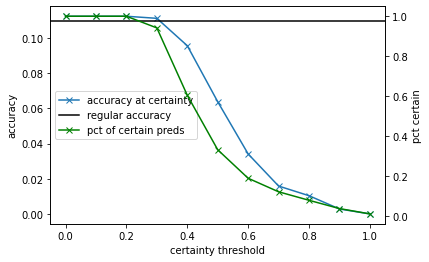

In [25]:
fashion_ds = tfds.load('fashion_mnist:3.*.*', split="test").cache().repeat()
fashion_test_batches = tfds.as_numpy(fashion_ds.batch(10_000))

fashion_batch = next(fashion_test_batches)
fa_pp = posterior_predictive(params, fashion_batch)
fa_acc = accuracy(params, fashion_batch)
fa_ent = jnp.mean(entropy(fa_pp))

print(f"acc = {fa_acc:.4f}"
      f" | entropy = {fa_ent:.4f} vs theoretical maximum {ent_upper_limit:.4f}")

thresholds = [0.1 * i for i in range(11)] 
fa_cert_accs, fa_pct_certs = [], []
for t in thresholds:
  fa_cert_acc, fa_cert_mask = certainty_acc(fa_pp, fashion_batch['label'], cert_threshold=t)
  fa_cert_accs.append(fa_cert_acc)
  fa_pct_certs.append(fa_cert_mask.mean())

f, ax = plt.subplots(1)
line1 = ax.plot(thresholds, fa_cert_accs, label='accuracy at certainty', marker='x')
line2 = ax.axhline(y=fa_acc, label='regular accuracy', color='black')
ax.set_ylabel('accuracy')
ax.set_xlabel('certainty threshold')

axb = ax.twinx()
line3 = axb.plot(thresholds, fa_pct_certs, label='pct of certain preds', 
                 color='green', marker='x')
axb.set_ylabel('pct certain')

lines = line1 + [line2] + line3
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=6)

plt.show()

This is much better! The predictive entropy is much higher for FashionMNIST as for MNIST, so the model is "surprised" to see images of pullovers and ankle-boots when it's used to classifying digits.

In addition, this plot says that model is 80% certain about only ~10% of its predictions, which is much better than the 90% of predictions passing the 80% certianty threshold for the optimization case.

## Conclusion: Bayesian Methods == Uncertainty